### Recruit Restaurant Visitor Forecasting

This is Jupyter Notebook submission of the group project within the scope of MGMT 328 class Advanced Topics in Data Analytics. The project was conducted on data from Kaggle competition on Restaurant Visitors. 

Running a thriving local restaurant isn't always as charming as first impressions appear. There are often all sorts of unexpected troubles popping up that could hurt business. One common predicament is that restaurants need to know how many customers to expect each day to effectively purchase ingredients and schedule staff members. This forecast isn't easy to make because many unpredictable factors affect restaurant attendance, like weather and local competition. It's even harder for newer restaurants with little historical data.

The data is collected from the following websites: Hot Pepper Gourmet (a restaurant review service), AirREGI (a restaurant point of sales service), and Restaurant Board (reservation log management software).

In competition and this project, our group were challenged to use reservation and visitation data to predict the total number of visitors to a restaurant for future dates. This information will help restaurants be much more efficient and allow them to focus on creating an enjoyable dining experience for their customers.

For more information see the report submission in pdf format. 

### Table of contents
1. [Importing libraries](#Importing libraries)
2. [Uploading data](#Uploading data)
 1. [Grouping data](#Grouping data)
3. [Exploratory Data Analysis](#EDA)
 1. [Stationarity test](#ST)
 2. [Autocorrelation](#acf)
4. [Modeling](#Modeling)
5. [Model Selection & Evaluation](#MSE)
6. [Summary](#Summary)

### Importing Libraries <a name="Importing libraries"></a>

In [2]:
#Importing starting libraries 
import pandas as pd
import numpy as np
import math

#Visualizations
import matplotlib.pyplot as plt
import seaborn as sn
import plotly as pl

#Models and functions
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.optimize import brute

#System specifics
import sys

#Evaluation metrics
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller

#Datetime modules
from datetime import datetime
import calendar

#Ignore warnings in sklearn
import warnings
warnings.filterwarnings("ignore")

#Magic to not call show every time 
%matplotlib inline

#Visualization standard parameters for all plots
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (20,3)

### Uploading data <a name="Uploading data"></a>
Within the scope of this project we used Air visit dataset which was retrieved from AirREGI (a wbsite similar to Yelp). Additionally date_info dataset was used for information on holiday days, since these will have important impact on the prediction models. Air visit data contains 3 columns: air_store_id, visit_date, No of visitors. Date_info contains 3 columns: calendar date, day of week, holiday(categorical variable, 1 for holiday, 0 for non holiday). Overall there are 252108 observations, yet we grouped observations for the same days: ended up to 458. 

In [3]:
#Uploading Air visit dataset
raw_data = pd.read_csv('air_visit_data.csv', parse_dates=[1], index_col=['visit_date'])
raw_data.index.name=None #Removing the name of the index column
raw_data.drop('air_store_id',axis=1,inplace=True) #dropping the useless column of id

print('Restaurant Visitors', '\n'*2, raw_data.head(3), "\n"*3)
print('Data Info', '\n'*2)
print(raw_data.info())

Restaurant Visitors 

             visitors
2016-01-13        25
2016-01-14        32
2016-01-15        29 



Data Info 


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 252108 entries, 2016-01-13 to 2017-04-22
Data columns (total 1 columns):
visitors    252108 non-null int64
dtypes: int64(1)
memory usage: 3.8 MB
None


#### Grouping data <a name="Grouping data"></a>
We have to groupby the number of visitors per each restaurant to have one number for a given date. 

In [4]:
air=pd.DataFrame() #air stands for AirREGI
air['visit_total'] = raw_data.groupby(raw_data.index,squeeze=True,sort=True)['visitors'].sum()#Grouping with aggregation
air['visit_mean'] = raw_data.groupby(raw_data.index,squeeze=True,sort=True)['visitors'].mean()#With averaging
air['reserv_cnt'] = raw_data.groupby(raw_data.index,squeeze=True,sort=True)['visitors'].count()#With count for reserved seats

print('Grouped Restaurant Visitors', '\n'*2, air.head(3), "\n"*3)
print('Data Info', '\n'*2)
print(air.info())

Grouped Restaurant Visitors 

             visit_total  visit_mean  reserv_cnt
2016-01-01         1033   21.520833          48
2016-01-02         1764   28.000000          63
2016-01-03         2368   29.234568          81 



Data Info 


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 478 entries, 2016-01-01 to 2017-04-22
Data columns (total 3 columns):
visit_total    478 non-null int64
visit_mean     478 non-null float64
reserv_cnt     478 non-null int64
dtypes: float64(1), int64(2)
memory usage: 14.9 KB
None


In [5]:
#Get the date info with day of the week and holidays
hol=pd.read_csv('date_info.csv', parse_dates=[1], index_col=['calendar_date']).rename(columns={'calendar_date':'visit_date'})
hol.index.name=None #Removing the name of the index column
hol.day_of_week = hol.day_of_week.apply(list(calendar.day_name).index) #Finding the day of the week from the calendar

print('DoW and Holidays', '\n'*2, hol.head(2), "\n"*3)
print('Data Info', '\n'*2)
print(hol.info())

DoW and Holidays 

             day_of_week  holiday_flg
2016-01-01            4            1
2016-01-02            5            1 



Data Info 


<class 'pandas.core.frame.DataFrame'>
Index: 517 entries, 2016-01-01 to 2017-05-31
Data columns (total 2 columns):
day_of_week    517 non-null int64
holiday_flg    517 non-null int64
dtypes: int64(2)
memory usage: 12.1+ KB
None


### Exploratory Data Analysis <a name="EDA"></a>
We found it more viable to apply the EDA on total visit, so this will convey the full picture of the initial data and the project. 

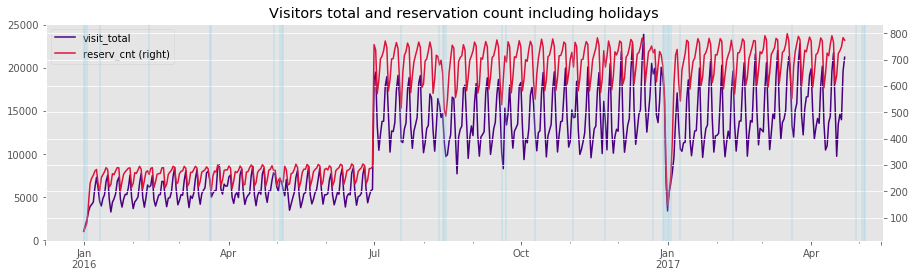

In [6]:
air['visit_total'].plot(legend=True, color = 'indigo')
air['reserv_cnt'].plot(legend=True, figsize=(15,4), secondary_y=True, color = 'crimson',
                      title='Visitors total and reservation count including holidays')

for x in hol.query('holiday_flg==1').index: #creating axvlines for holidays
    _ = plt.axvline(x=x, color='skyblue', alpha = 0.3)

There are shifts in the graph beacuse of two reasons: data was collected from more restaurants starting from July 2016 and usually restaurants are being closed for New Year Evenings.

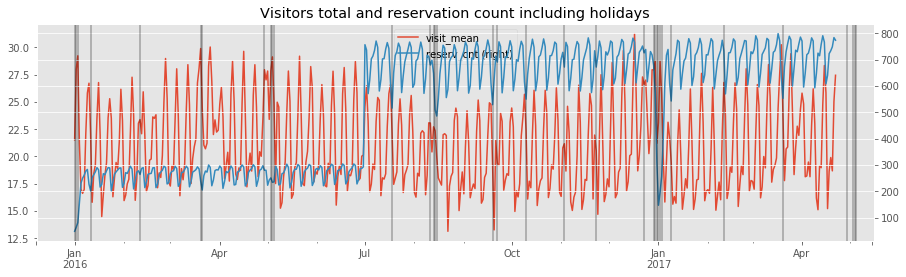

In [8]:
ax1 = air['visit_mean'].plot(legend=True)
ax2 = air['reserv_cnt'].plot(legend=True,figsize=(15,4), 
                       secondary_y=True, title='Visitors total and reservation count including holidays')
for x in hol.query('holiday_flg==1').index:
    _ = plt.axvline(x=x, color='k', alpha = 0.3)

<Figure size 432x288 with 0 Axes>

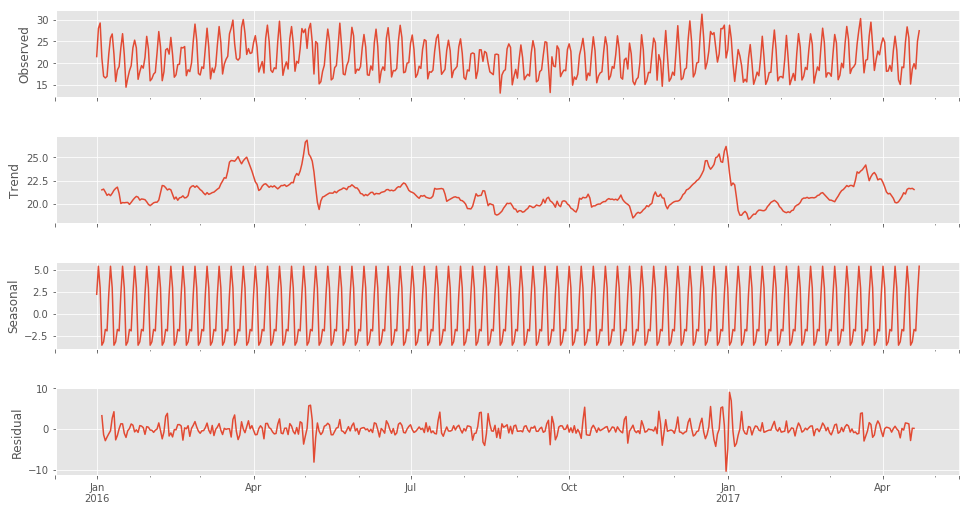

In [22]:
#Creating seasonal decompositition plot using moving average additive formula. 
#Time series decomposition is a mathematical procedure which transforms a time series into multiple different time series. 
#The original time series is often split into 3 component series 
decomposition = seasonal_decompose(air.visit_mean, model = 'addititve')  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

#### Stationarity test <a name="ST"></a>
We defined a function tthat will test for stationarity. So, we have to check statistical properties such as mean, variance, autocorrelation, are all constant over time. Initially the function determines the rolling statistics, creates figure for the plot of statisitics. Then the function applies Dickey Fuller test of stationarity by outputing p-value, test statistic, critical values.  

In [24]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12,center=False).mean();
    rolstd = timeseries.rolling(window=12,center=False).std();

    #Plot rolling statistics:
    fig = plt.figure(figsize=(15, 5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

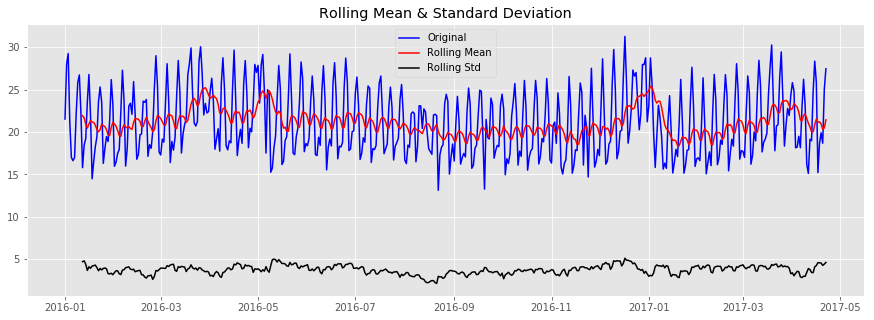

Results of Dickey-Fuller Test:
Test Statistic                  -3.796104
p-value                          0.002947
#Lags Used                      16.000000
Number of Observations Used    461.000000
Critical Value (1%)             -3.444615
Critical Value (5%)             -2.867830
Critical Value (10%)            -2.570120
dtype: float64


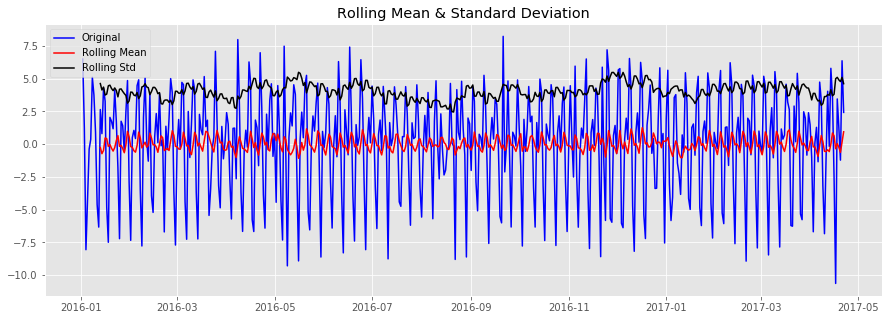

Results of Dickey-Fuller Test:
Test Statistic                -6.608968e+00
p-value                        6.448883e-09
#Lags Used                     1.800000e+01
Number of Observations Used    4.580000e+02
Critical Value (1%)           -3.444709e+00
Critical Value (5%)           -2.867871e+00
Critical Value (10%)          -2.570142e+00
dtype: float64


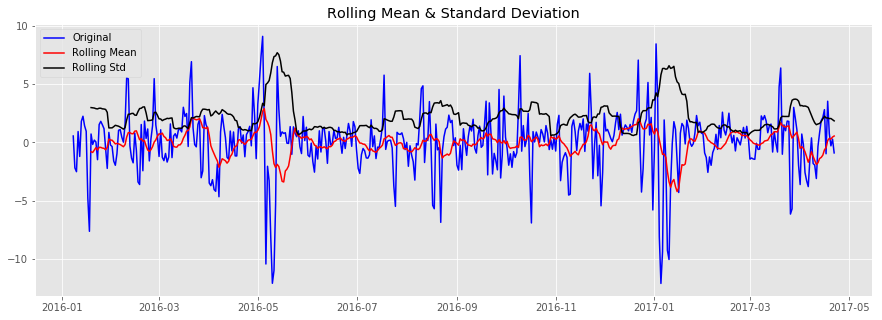

Results of Dickey-Fuller Test:
Test Statistic                -7.196314e+00
p-value                        2.429479e-10
#Lags Used                     1.500000e+01
Number of Observations Used    4.550000e+02
Critical Value (1%)           -3.444804e+00
Critical Value (5%)           -2.867913e+00
Critical Value (10%)          -2.570165e+00
dtype: float64


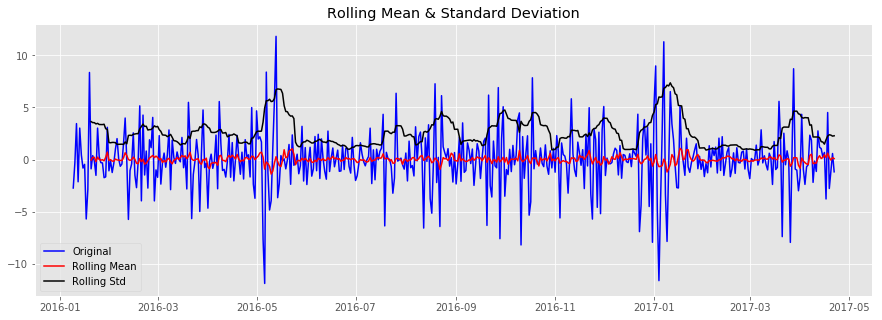

Results of Dickey-Fuller Test:
Test Statistic                -9.427797e+00
p-value                        5.288819e-16
#Lags Used                     1.600000e+01
Number of Observations Used    4.530000e+02
Critical Value (1%)           -3.444868e+00
Critical Value (5%)           -2.867941e+00
Critical Value (10%)          -2.570180e+00
dtype: float64


In [23]:
test_stationarity(air.visit_mean) #-3.796104
# Log is a minor improvement, meaning that the variance is stable
air.visit_mean_log= air.visit_mean.apply(lambda x: np.log(x))  
'''test_stationarity(air.visit_mean_log) #-3.830754'''
# Although I see no real global trend, 1st difference strongly improves stationarity
air['visit_mean_diff'] = air.visit_mean - air.visit_mean.shift(1)  
test_stationarity(air.visit_mean_diff.dropna(inplace=False)) #-6.608968e+00
# Seasonal difference: take a weekly season improves stationarity even more
air['visit_mean_seasonal'] = air.visit_mean - air.visit_mean.shift(7)
test_stationarity(air.visit_mean_seasonal.dropna(inplace=False)) #-7.196314e+00
# Seasonal and 1st difference is even better, but we were already well within the 1% confidence interval
air['visit_mean_seasonal_diff'] = air.visit_mean_diff - air.visit_mean_diff.shift(7)
test_stationarity(air.visit_mean_seasonal_diff.dropna(inplace=False)) #-9.427797e+00

#### ACF & PACF <a name="acf"></a>
Stationarity tests are continued by applying the Autocorrelation and Partial Autocorrelation on Mean Visits and Seasonal Lags.  

ACF and PACF of the visit mean:


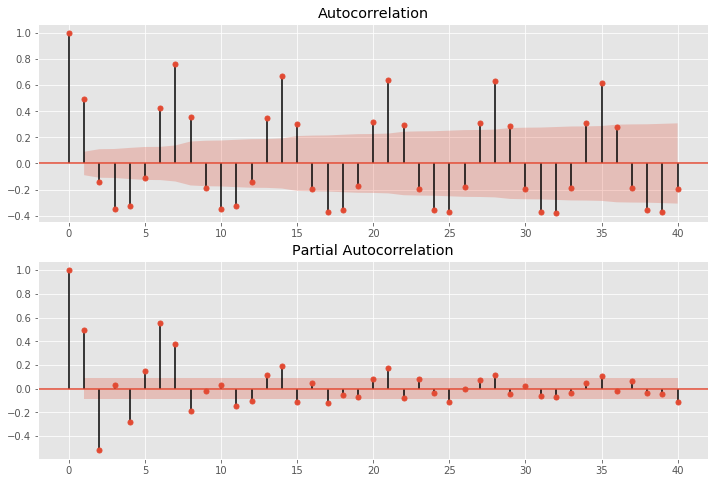

In [11]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(air.visit_mean, lags=40, alpha=.05, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(air.visit_mean, lags=40, alpha=.05, ax=ax2)
print("ACF and PACF of the visit mean:")

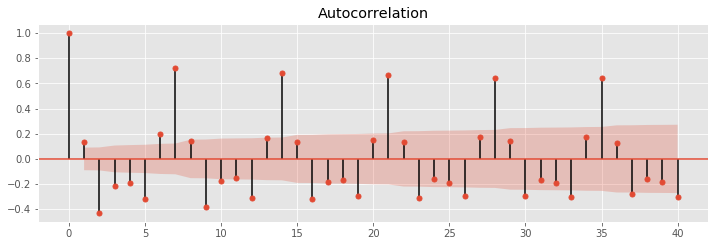

In [12]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(air.visit_mean_diff[1:], lags=40, alpha=.05, ax=ax1)

ACF and PACF of the 7-day differenced visit mean:


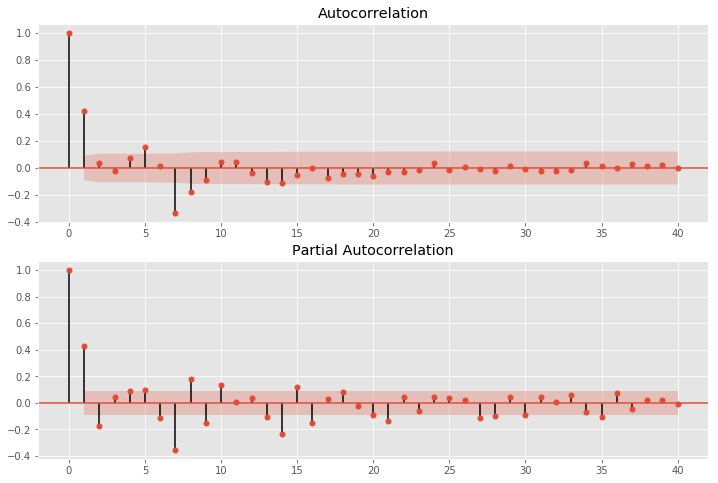

In [13]:
print("ACF and PACF of the 7-day differenced visit mean:")
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(air.visit_mean_seasonal[8:], lags=40, alpha=.05, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(air.visit_mean_seasonal[8:], lags=40, alpha=.05, ax=ax2)

### Modeling <a name="Modeling"></a>
Our group decided to use the Mean Squared Logarithmic Error as an evaluation metric, because it was one of the rules of the competition. Sklearn library does not provide mean squared logarithmic error metrics by default, that is why we defined function for this metric.   

In [14]:
def mean_squared_log_error(y_pred, y_true, **dict):
    '''Assume y_true starts earlier than y_pred, y_true is NaN free, and NaN in y_pred are only in the beginning'''
    indafterNaN = y_pred.first_valid_index()
    if (y_true.index[0] > y_pred.index[0]): return "Check indices of prediction and true value"
    ind1stcommon = y_true.index[y_true.index==y_pred.index[0]]
    indstart = max(indafterNaN, ind1stcommon)
    indend = y_true.index[-1]
    return mean_squared_error(np.log(y_true[indstart:indend]+1), 
                              np.log(y_pred[indstart:indend]+1) )**0.5

def plotSARIMAX(labels, pred):
    fig = plt.figure(figsize=(12, 8))
    layout = (2, 2)
    ax1 = plt.subplot2grid(layout, (0, 0), colspan=2)
    ax3 = plt.subplot2grid(layout, (1, 0))
    ax4 = plt.subplot2grid(layout, (1, 1))
    labels.plot(ax=ax1)
    pred.plot(ax=ax1, title='MSE: %.4f'% mean_squared_log_error(pred, labels))
    ax3 = sm.graphics.tsa.plot_acf(results.resid, lags=40, alpha=.05, ax=ax3, title="ACF of residuals")
    ax4 = sm.graphics.tsa.plot_pacf(results.resid, lags=40, alpha=.05, ax=ax4, title="PACF of residuals")
    plt.tight_layout()
    print("ACF and PACF of residuals")

### Model Selection and Evaluation <a name="MSE"></a>

In [15]:
def autoSARIMAX(endog, exog=None, date_train_end=None, pred_days=[-12,12], verbose=True,\
        ranges=(slice(1,3),slice(0,1),slice(1,3),  slice(0,2),slice(1,2),slice(1,2),slice(7,8))):
    #Instantiate my version of the grid with parameters and scores
    global grid
    grid = []
    #Get indices up to which you do train and prediction 
    if date_train_end is None:
        ind_train = endog.index[-1]
    else:
        ind_train = np.where(endog.index==date_train_end)[0][0]
    #Brute optimization
    resultsbrute = brute(runSARIMAX, ranges=ranges, args=(endog,exog,(ind_train,pred_days),), full_output=True, finish=None)
    #First coefficients run two times for some reason or another
    del grid[0]
    #Print/Plot results
    if verbose:
        print("Best parameters: {}".format([int(p) for p in resultsbrute[0]]))
        print("Best score:          {}".format(resultsbrute[1]))
        gr = plotautoSARIMAX(resultsbrute, verbose)
    return resultsbrute, gr

def plotautoSARIMAX(resultsbrute, verbose=True):
    #Print/Plot results
    if not verbose: return None
    #Plot scores by parameter values
    gr = pd.DataFrame({'params':[''.join(str(n) for n in g[0]) for g in grid], 'score': [row[1] for row in grid], 'aic': [row[2] for row in grid]})
    print("All parameters and scores: \n")
    print(gr.head(1000).to_string())
    ax1 = gr.plot('params','score',rot=90, grid=True, figsize=(15,4))
    ax2 = gr.plot('params','aic',rot=90, secondary_y=True,ax=ax1)
    ax1.set_ylabel('Score');ax2.set_ylabel('AIC');
    plt.xticks(range(len(gr)), gr.params, rotation=90);
    return gr

def runSARIMAX(coeffs, *args):
    endog = args[0]
    exog = args[1]
    #Process the row indices for training and prediction
    ind_train = args[2][0]
    pred_days = args[2][1]
    ind_pred = [len(endog)+pred_days[0], len(endog)+pred_days[1]]
    if ind_pred[0] > ind_train: 
        #ind_pred[0]=ind_train
        raise ValueError('Make sure prediction bounds begin at least at len(endog): pred_days[0] must be <= %i ' % (ind_train-len(endog)))
    exog_train, exog_pred, start_params = None, None, list()
    if exog is not None:
        if ind_pred[1] > len(exog):
            raise ValueError('Make sure prediction bounds end  <= len(exog): pred_days[1] must be <= %i ' % (len(exog)-len(endog)))
        exog_train = exog[:ind_train]
        exog_cols = 1 if len(exog.shape) == 1 else exog.shape[1]
        start_params.extend(0.1*np.ones(exog_cols-1))
        exog_pred = exog[ind_pred[0]-1:ind_pred[1]]
        exog_pred = pd.DataFrame(exog_pred)
        
    #Get the hyperparameters
    order = coeffs[0:3].tolist()
    seasonal_order = coeffs[3:7].tolist()
    trend = 'c' if (order[1]==0) else 'n'
    #Train SARIMAX and fit it on data, predict to get scores
    try:        
        mod = sm.tsa.statespace.SARIMAX(endog[:ind_train], exog_train, \
                                        trend=trend, order=order, seasonal_order=seasonal_order)
        start_params.extend(0.1*np.ones( len(mod.params_complete)))
        fit = mod.fit(start_params=start_params)
        pred = fit.predict(start=ind_pred[0], end=ind_pred[1], exog=exog_pred)
        aic = fit.aic
        score = mean_squared_log_error(pred[:-pred_days[0]], endog[ind_pred[0]:])        
        if np.isnan(aic): aic, score = np.inf, np.inf
    except:  #Tip: Try to set starting paramenters in .fit()
        print("Error:", sys.exc_info()) #This function returns a tuple of three values that give information about the exception that is currently being handled.       
        print("{},{},'{}', len(start_params)={}\n".format(coeffs[0:3], coeffs[3:], trend, len(start_params)))
        aic, score = np.inf, np.inf
    #Sorry but I don't like the grid in the output of brute resultsbrute[2]
    global grid
    grid.append([coeffs,score,aic])
    return score

Best parameters: [1, 0, 2, 0, 1, 1, 7]
Best score:          0.06995603474034778
All parameters and scores: 

     params     score          aic
0   1010117  0.078651  1862.338447
1   1011117  0.075001  1847.452561
2   1020117  0.069956  1837.934564
3   1021117  0.072501  1832.623665
4   1110117  0.092012  1872.663436
5   1111117  0.089565  1861.546496
6   1120117  0.101336  1845.481739
7   1121117  0.103011  1839.896204
8   2010117  0.077763  1861.588401
9   2011117  0.074779  1847.328602
10  2020117  0.070055  1837.873843
11  2021117  0.073544  1832.561732
12  2110117  0.115138  1838.895627
13  2111117  0.119437  1835.609497
14  2120117  0.115611  1838.886994
15  2121117  0.118143  1835.559868


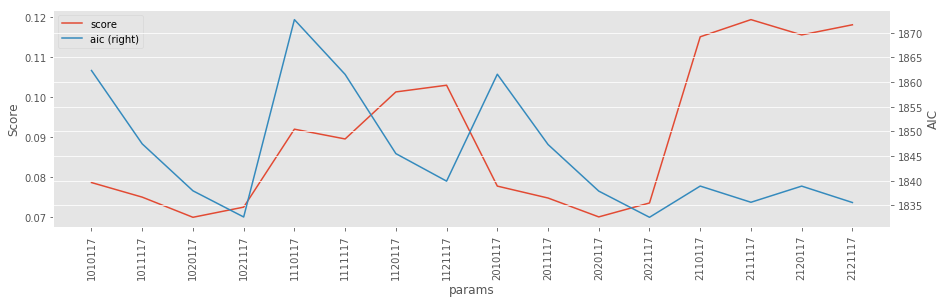

In [16]:
resbrute, gr = autoSARIMAX(endog=air.visit_mean, exog=None, date_train_end="2017-03-26", pred_days = [-28,39],\
                             ranges=(slice(1,3),slice(0,2),slice(1,3),  slice(0,2),slice(1,2),slice(1,2),slice(7,8)))
#Not visible, but the SMA parameter is important to keep to 1

                                 Statespace Model Results                                
Dep. Variable:                        visit_mean   No. Observations:                  450
Model:             SARIMAX(1, 0, 2)x(1, 1, 1, 7)   Log Likelihood                -907.244
Date:                           Wed, 08 May 2019   AIC                           1828.488
Time:                                   08:24:58   BIC                           1857.143
Sample:                               01-01-2016   HQIC                          1839.789
                                    - 03-25-2017                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0004      0.001     -0.349      0.727      -0.003       0.002
ar.L1          0.9450      0.030     31.398

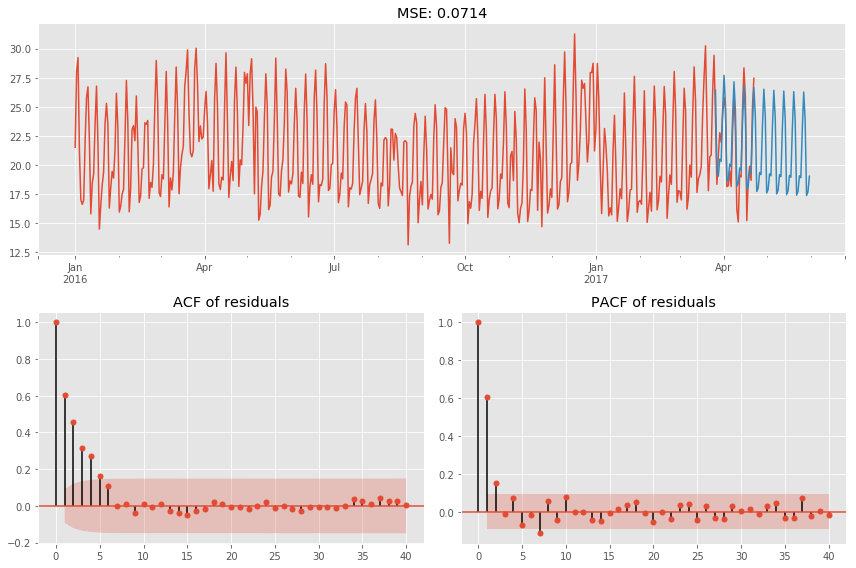

In [17]:
mod = sm.tsa.statespace.SARIMAX(air.visit_mean[:450], trend='c', order=(1,0,2), seasonal_order=(1,1,1,7))
results = mod.fit()
#Predict on future data and on time periods already known for evaluation with RMSLE
pred = results.predict(start=450, end=516)
print(results.summary())
#Plot
plotSARIMAX(air.visit_mean, pred)

### Summary <a name="Summary"></a>

The project provided a SARIMA model for restaurant visitor prediction with MSLE accuracy of 0.0714. The latter can be considered a fairly robust result for this type of time series data. Seasonality was identified on weekly data, which helped us in initial modeling. After applying the Grid Search Algorithm, we ended up with the (1,0,2)x(1,1,1,7) model. 
The project can be considered a fairly useful tool for HoReCa businesses since it not only provides a forecasting model for visitor data but also demonstrates applicable plots regarding the operations. The model can be further modified to meet specific business needs. For example, mean check value, variable, fixed costs and other financial statements components can be integrated into the model to predict financial components. 
Further work will include the test of the model on data retrieved from other sources. In particular, our team has created a scraper to retrieve reservation data from the local reservation website, which publicly provides the number of available seats in more than 100 cafes and restaurants. Additionally, our team would like to add variables to the predictive model.  